## Load the training/test datasets

In [1]:
from os.path import join
import xml.etree.ElementTree as ET
import numpy as np

from corpus import *

In [2]:
def load_dataset(dataset_filepath, truth_filepath):
    """ Given the paths where the corpus is, load it within a Corpus class

    Args:
        dataset_filepath (str): path where the PAN XMLs files are.
        truth_filepath (str): path where the ground truht is.

    Returns:
        Corpus: return all the samples within a Corpus class
    """
    dataset = Corpus()
    with open(truth_filepath) as truth_file:
        for line in truth_file.readlines():

            line_split = line.strip().split(':::')
            author_id, gender, age_range = line_split[:3]
            personality = Personality(extrovert=float(line_split[3]),
                                      stable=float(line_split[4]),
                                      agreeable=float(line_split[4]),
                                      conscientious=float(line_split[5]),
                                      open_trait=float(line_split[6]))

            # Read the tweets for the author in hand
            author_tweets_filepath = join(dataset_filepath, author_id + ".xml")
            tree = ET.parse(author_tweets_filepath)
            
            root = tree.getroot()
            current_author = Author(author_id, gender, age_range, personality)
            for num, child in enumerate(root):
                current_author.add(child.text)
            dataset.add(current_author)

    return dataset


In [3]:
def load_data():
    PAN_DATASET = "/Users/maite/Dev/corpora/PAN/"
    DATASET_FILEPATH = join(PAN_DATASET, "pan15-author-profiling-training-dataset-english-2015-04-23")
    TRUTH_FILEPATH = join(DATASET_FILEPATH, "truth.txt")
    training_dataset = load_dataset(DATASET_FILEPATH, TRUTH_FILEPATH)

    TEST_FILEPATH = join(PAN_DATASET, "pan-ap2015-test")
    DATASET_FILEPATH = join(TEST_FILEPATH, "en")
    TRUTH_FILEPATH = join(TEST_FILEPATH, "en.txt")
    test_dataset = load_dataset(DATASET_FILEPATH, TRUTH_FILEPATH)

    return training_dataset, test_dataset

Load the datasets to train and test the models

In [4]:
training_dataset, test_dataset = load_data()

Get the length of the sequence. Since it's padded, each sentence has the same length.

In [5]:
for t in training_dataset._samples[:5]:
    print(t)

* #3e2cdc34-b [100]
  - Age: 25-34, Gender: M 
  - E: 0.3, S: 0.5 , A: 0.5, C: 0.1, O: 0.1
* #b38fee80-2 [100]
  - Age: 25-34, Gender: M 
  - E: 0.2, S: 0.4 , A: 0.4, C: 0.2, O: 0.2
* #60468a75-1 [100]
  - Age: 18-24, Gender: M 
  - E: 0.1, S: 0.2 , A: 0.2, C: 0.1, O: 0.1
* #e78b60f0-b [100]
  - Age: 18-24, Gender: F 
  - E: 0.1, S: 0.1 , A: 0.1, C: -0.1, O: -0.1
* #f1dcc4ff-0 [100]
  - Age: 18-24, Gender: F 
  - E: 0.0, S: -0.1, A: -0.1, C: 0.1, O: 0.1


In [6]:
for t in test_dataset._samples[:5]:
    print(t)

* #81db75e5-a [100]
  - Age: 25-34, Gender: F 
  - E: 0.4, S: 0.5 , A: 0.5, C: 0.2, O: 0.2
* #ba09b307-7 [100]
  - Age: 50-XX, Gender: M 
  - E: 0.1, S: 0.1 , A: 0.1, C: 0.1, O: 0.1
* #9d4e5977-9 [100]
  - Age: 18-24, Gender: M 
  - E: 0.3, S: 0.4 , A: 0.4, C: 0.2, O: 0.2
* #88c6136e-f [100]
  - Age: 25-34, Gender: M 
  - E: 0.4, S: 0.4 , A: 0.4, C: 0.4, O: 0.4
* #97dc68f2-5 [100]
  - Age: 25-34, Gender: F 
  - E: 0.2, S: 0.0 , A: 0.0, C: 0.0, O: 0.0


### So..., How many tweet do we have for traning?
For each author there are a number of tweets in the dataset

In [7]:
training_str = 'The mininum numbers of tweets for an author is {} in training and {} in test'
print(training_str.format(training_dataset.min(), test_dataset.min()))
testing_str = 'The maximum numbers of tweets for an author is {} in training and {} in test'
print(testing_str.format(training_dataset.max(),  test_dataset.max()))

The mininum numbers of tweets for an author is 32 in training and 26 in test
The maximum numbers of tweets for an author is 100 in training and 100 in test


In [8]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

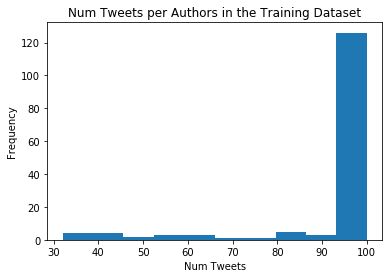

In [9]:
num_tweets_train = training_dataset.num_tweets()
plt.hist(num_tweets_train)
plt.title("Num Tweets per Authors in the Training Dataset")
plt.xlabel("Num Tweets")
plt.ylabel("Frequency")
plt.show()

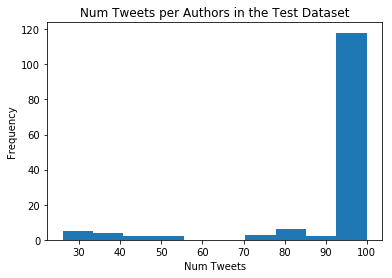

In [10]:
num_tweets_test = test_dataset.num_tweets()
plt.hist(num_tweets_test)
plt.title("Num Tweets per Authors in the Test Dataset")
plt.xlabel("Num Tweets")
plt.ylabel("Frequency")
plt.show()

# Get the data ready

In [11]:
import numpy as np

from gensim.models import word2vec

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input, Merge, Convolution1D, MaxPooling1D

from sklearn.model_selection import train_test_split
np.random.seed(2)

Using TensorFlow backend.


## Pad the data
Each sentece has different lenghts. But our CNN models needs a fixed-size input. Hence, we include zeros at the ende so each sentence will have the same number of words.

In [12]:
max_sequence = training_dataset.pad()
_ = test_dataset.pad(max_sequence)

## Get the text from tweets

In [13]:
x_train = [tweet for author in training_dataset.samples for tweet in author.padded ]
x_test = [tweet for author in test_dataset.samples for tweet in author.padded ]
num_test = [len(author.padded) for author in test_dataset.samples]
seq_len = len(x_train[0])

### Create the lookup matrix and the vocabulary

In [14]:
from collections import Counter
from itertools import chain

def build_vocab(dataset, to_lower=False):
    """ Create a lookup table and a list with the vocabulary.

    Args:
        dataset (list): a matrix with the words from the dataset

    Returns:
        vocab_sorted (list): list of the words sorted by its frequency
        lookup (dict): a dictionary with the lookup table. The keys are
            the words and the values are the indexes.
    """
    # Count how many times a word appear in the dataset
    word_counts = Counter(chain(*dataset))
    # Create a list with the most common words sorted.
    # The position will be the index of the lookup table.
    vocab_sorted = []
    for word, _ in word_counts.most_common():
        if to_lower:
            word = word.lower()
        if word not in vocab_sorted:
            vocab_sorted.append(word)
    vocab_sorted.append('<oov>')
    # Create a lookup table using a dictionary. Map each index with a word
    lookup = {word: index for index, word in enumerate(vocab_sorted)}

    # TODO: Move this to the unittest
    assert len(list(lookup.keys())) == len(vocab_sorted)

    return vocab_sorted, lookup

In [15]:
vocab_sorted, lookup = build_vocab(x_train)

In [16]:
print("Vocabulary Size: {:d}".format(len(vocab_sorted)))

Vocabulary Size: 33240


### Convert text to indexes 

In [17]:
def to_indexes(sentences, vocabulary):
    """ Convert a list of sentences to its corresponding indices.

    Args:
        sentences: a list where each element is a lists of words (sentences)
        vocabulary: a dictionary of words and its corresponding index

    Returns:
        a list where each element is a list of indexes (sentences)

    """
    senteces_idx = []
    for sentence in sentences:
        aux_idx = []
        for word in sentence:
            # If the word is in the vocabulary get its index otherwise use the <oov> index
            if word in vocabulary:
                word_idx = vocabulary[word]
            else:
                word_idx = vocabulary['<oov>']
            aux_idx.append(word_idx)
        senteces_idx.append(aux_idx)
    return np.array(senteces_idx)


In [18]:
x_train_idx = to_indexes(x_train, lookup)
x_test_idx = to_indexes(x_test, lookup)

In [19]:
print("Number of training samples: {}".format(x_train_idx.shape[0]))
print("Number of test samples: {}".format(x_test_idx.shape[0]))
print("Number of words per sample: {}".format(x_train_idx.shape[1]))
assert x_train_idx.shape[1] == x_test_idx.shape[1]

Number of training samples: 14166
Number of test samples: 13178
Number of words per sample: 44


In [20]:
unseen_words = sum([1 for tweet in x_test_idx for word in tweet if word==lookup['<oov>']])
total_word = (unseen_words/sum([1 for tweet in x_test_idx for word in tweet]))*100
print("The number of unseen words in test is {}, "\
      "which represents a {:.2f}% of the total.".format(unseen_words, total_word))

The number of unseen words in test is 24783, which represents a 4.27% of the total.


Get a list with the number of tweets per user

In [21]:
tweets_user = np.array([len(author.padded) for author in test_dataset.samples])

## Get the labels and encode them
We are only trying to get those labels for which we have samples. This is a somewhat tricky but it will improve the performance of the sistem including this prior knowledge

In [22]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [23]:
def encode_trait(trait, training_dataset, test_dataset):
    """ Encode the traits for training and testing. """
    y_train = np.array([getattr(author.personality, trait)
                        for author in training_dataset.samples
                        for _ in author.padded])
    y_test = np.array([getattr(author.personality, trait)
                       for author in test_dataset.samples
                       for _ in author.padded])
    # Get only a label for each author
    y_test_group = np.array([getattr(author.personality, trait)
                             for author in test_dataset.samples])

    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_train = encoder.transform(y_train)
    encoded_test = encoder.transform(y_test)

    oneh_train = np_utils.to_categorical(encoded_train)
    oneh_test = np_utils.to_categorical(encoded_test)

    return oneh_train, oneh_test, y_test_group, encoder

# Create a CNN model initialized with random noise

In [24]:
from keras import metrics
from keras.layers.merge import Concatenate
from sklearn.metrics import mean_squared_error

### Model parameters

In [25]:
model_variation = 'CNN-rand'  #  CNN-rand | CNN-non-static | CNN-static
print('Model variation is %s' % model_variation)

Model variation is CNN-rand


In [26]:
# Model Hyperparameters
sequence_length = len(x_train[0])
embedding_dim = 50          
num_filters = 100
dropout_prob = (0.5,)
hidden_dims = (1024, 128)
filters_h = (3, 4, 5)

batch_size = 100
num_epochs = 10

output_classes =  9

### Define the model

In [27]:
from keras.wrappers.scikit_learn import KerasRegressor
from math import sqrt

def cnn_model(sequence_length, embedding_dim, num_filters, filtes_h, model_variation, 
              dropout_prob, hidden_dims, output_neurons, verbose=False, embedding_weights=None):

    # Input
    if model_variation == "CNN-static":
        input_shape = (sequence_length, embedding_dim)
        model_input = Input(shape=input_shape)
        embedding_input = model_input
    elif model_variation == "CNN-pre_static":
        input_shape = (sequence_length,)
        model_input = Input(shape=input_shape)
        embedding_input = Embedding(len(vocab_sorted), embedding_dim, input_length=sequence_length, 
                                    weights=embedding_weights, trainable=False)(model_input)
        
    else:
        input_shape = (sequence_length,)
        model_input = Input(shape=input_shape)
        embedding_input = Embedding(len(vocab_sorted), embedding_dim, input_length=sequence_length,
                        weights=embedding_weights)(model_input)
        print("Embedding dim:", len(vocab_sorted), embedding_dim)

    # CNNs
    convs = []
    for fh in filtes_h:
        # TODO Change the stride
        conv = Convolution1D(filters=num_filters,
                             kernel_size=fh,
                             padding='valid',
                             activation='relu',
                             strides=1)(embedding_input)
        pool = MaxPooling1D(pool_size=2)(conv)
        flatten = Flatten()(pool)
        convs.append(flatten)

    concat_layer = Concatenate(axis=-1)(convs)
    dropout_cnn = Dropout(dropout_prob[0])(concat_layer)

    h1 = Dense(hidden_dims[0], activation="relu")(dropout_cnn)
    h2 = Dense(hidden_dims[1], activation="relu")(h1)
    model_output = Dense(output_neurons, activation="sigmoid")(h2)

    model = Model(inputs=model_input, outputs=model_output)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.mean_squared_error])
    if verbose:
        print(model.summary())
    return model

In [28]:
def group_prediction(predictions_decoded, tweets_user):
    groups = []
    ini = 0
    for num_tweets in tweets_user:
        groups.append(np.mean(predictions_decoded[ini:ini + num_tweets]))
        ini += num_tweets

    return groups

### Train the model

In [29]:
verbose = True
rmses = []
model = cnn_model(sequence_length, embedding_dim, num_filters, filters_h, model_variation, 
                      dropout_prob, hidden_dims, output_classes, verbose)

Embedding dim: 33240 50
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 44)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 44, 50)        1662000                                      
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 42, 100)       15100                                        
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 41, 100)       20100                                        
___________________________________________________________________

#### Extrovert

In [30]:
trait = 'extroverted'
oh_train, oh_test, test_grouped, encoder = encode_trait(trait, training_dataset, test_dataset)
model.fit(x_train_idx[:13000], oh_train[:13000], batch_size=batch_size,
          epochs=num_epochs, validation_data=(x_train_idx[13000:], oh_train[13000:]))
loss, rmse = model.evaluate(x_test_idx, oh_test, verbose=0)
rmse_str = 'RMSE for trait {}: {:.4f} RMSE/per trait'
print(rmse_str.format(trait, sqrt(rmse)))

Train on 13000 samples, validate on 1166 samples
Epoch 1/10
13000/13000 [==============================] - 73s - loss: 0.1031 - mean_squared_error: 0.1031 - val_loss: 0.1040 - val_mean_squared_error: 0.1040

In [31]:
predictions = model.predict(x_test_idx)
predictions_decoded = encoder.inverse_transform([np.argmax(p) for p in predictions])

grouped_predictions = group_prediction(predictions_decoded, tweets_user)
rmse_person = np.sqrt(mean_squared_error(test_grouped, grouped_predictions))
print("The RMSE for the trait {} is {:.4f}".format(trait, rmse_person))
rmses.append(rmse_person)

The RMSE for the trait extroverted is 0.1530


#### Stable

In [32]:
trait = 'stable'
oh_train, oh_test, test_grouped, encoder = encode_trait(trait, training_dataset, test_dataset)
model.fit(x_train_idx[:13000], oh_train[:13000], batch_size=batch_size,
          epochs=num_epochs, validation_data=(x_train_idx[13000:], oh_train[13000:]))
loss, rmse = model.evaluate(x_test_idx, oh_test, verbose=0)
rmse_str = 'RMSE for trait {}: {:.4f} RMSE/per trait'
print(rmse_str.format(trait, sqrt(rmse)))

predictions = model.predict(x_test_idx)
predictions_decoded = encoder.inverse_transform([np.argmax(p) for p in predictions])

grouped_predictions = group_prediction(predictions_decoded, tweets_user)
rmse_person = np.sqrt(mean_squared_error(test_grouped, grouped_predictions))
print("The RMSE for the trait {} is {:.4f}".format(trait, rmse_person))
rmses.append(rmse_person)

Train on 13000 samples, validate on 1166 samples
Epoch 1/10
13000/13000 [==============================] - 64s - loss: 0.1160 - mean_squared_error: 0.1160 - val_loss: 0.1111 - val_mean_squared_error: 0.1111

#### Agreeable

In [33]:
trait = 'agreeable'
oh_train, oh_test, test_grouped, encoder = encode_trait(trait, training_dataset, test_dataset)
model.fit(x_train_idx[:13000], oh_train[:13000], batch_size=batch_size,
          epochs=num_epochs, validation_data=(x_train_idx[13000:], oh_train[13000:]))
loss, rmse = model.evaluate(x_test_idx, oh_test, verbose=0)
rmse_str = 'RMSE for trait {}: {:.4f} RMSE/per trait'
print(rmse_str.format(trait, sqrt(rmse)))

predictions = model.predict(x_test_idx)
predictions_decoded = encoder.inverse_transform([np.argmax(p) for p in predictions])

grouped_predictions = group_prediction(predictions_decoded, tweets_user)
rmse_person = np.sqrt(mean_squared_error(test_grouped, grouped_predictions))
print("The RMSE for the trait {} is {:.4f}".format(trait, rmse_person))
rmses.append(rmse_person)

Train on 13000 samples, validate on 1166 samples
Epoch 1/10
13000/13000 [==============================] - 61s - loss: 0.1111 - mean_squared_error: 0.1111 - val_loss: 0.1111 - val_mean_squared_error: 0.1111

#### Conscientious

In [34]:
trait = 'conscientious'
oh_train, oh_test, test_grouped, encoder = encode_trait(trait, training_dataset, test_dataset)
model.fit(x_train_idx[:13000], oh_train[:13000], batch_size=batch_size,
          epochs=num_epochs, validation_data=(x_train_idx[13000:], oh_train[13000:]))
loss, rmse = model.evaluate(x_test_idx, oh_test, verbose=0)
rmse_str = 'RMSE for trait {}: {:.4f} RMSE/per trait'
print(rmse_str.format(trait, sqrt(rmse)))

predictions = model.predict(x_test_idx)
predictions_decoded = encoder.inverse_transform([np.argmax(p) for p in predictions])

grouped_predictions = group_prediction(predictions_decoded, tweets_user)
rmse_person = np.sqrt(mean_squared_error(test_grouped, grouped_predictions))
print("The RMSE for the trait {} is {:.4f}".format(trait, rmse_person))
rmses.append(rmse_person)

Train on 13000 samples, validate on 1166 samples
Epoch 1/10
13000/13000 [==============================] - 52s - loss: 0.1111 - mean_squared_error: 0.1111 - val_loss: 0.1111 - val_mean_squared_error: 0.1111

#### Open

In [35]:
trait = 'open'
model = cnn_model(sequence_length, embedding_dim, num_filters, filters_h, model_variation, 
                      dropout_prob, hidden_dims, 8, False)
oh_train, oh_test, test_grouped, encoder = encode_trait(trait, training_dataset, test_dataset)
model.fit(x_train_idx[:13000], oh_train[:13000], batch_size=batch_size,
          epochs=num_epochs, validation_data=(x_train_idx[13000:], oh_train[13000:]))
loss, rmse = model.evaluate(x_test_idx, oh_test, verbose=0)
rmse_str = 'RMSE for trait {}: {:.4f} RMSE/per trait'
print(rmse_str.format(trait, sqrt(rmse)))

predictions = model.predict(x_test_idx)
predictions_decoded = encoder.inverse_transform([np.argmax(p) for p in predictions])

grouped_predictions = group_prediction(predictions_decoded, tweets_user)
rmse_person = np.sqrt(mean_squared_error(test_grouped, grouped_predictions))
print("The RMSE for the trait {} is {:.4f}".format(trait, rmse_person))
rmses.append(rmse_person)

Embedding dim: 33240 50
Train on 13000 samples, validate on 1166 samples
Epoch 1/10
13000/13000 [==============================] - 51s - loss: 0.1073 - mean_squared_error: 0.1073 - val_loss: 0.0941 - val_mean_squared_error: 0.0941

In [36]:
print("The mean RMSE achieved is {:.4f}".format(np.mean(rmses)))

The mean RMSE achieved is 0.2600


# Create a CNN model initialized with trained word embeddings

In [37]:
from gensim.models import word2vec

def train_word2vec(sentence_matrix, vocabulary_inv,
                   num_features=300, min_word_count=1, context=10):
    """
    Trains, saves, loads Word2Vec model
    Returns initial weights for embedding layer.
   
    inputs:
    sentence_matrix # int matrix: num_sentences x max_sentence_len
    vocabulary_inv  # dict {str:int}
    num_features    # Word vector dimensionality                      
    min_word_count  # Minimum word count                        
    context         # Context window size 
    """

    # Set values for various parameters
    num_workers = 2       # Number of threads to run in parallel
    downsampling = 1e-3   # Downsample setting for frequent words
        
    # Initialize and train the model
    print ("Training Word2Vec model...")
    embedding_model = word2vec.Word2Vec(sentence_matrix, workers=num_workers, \
                            size=num_features, min_count = min_word_count, \
                            window = context, sample = downsampling)
        
    # If we don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    embedding_model.init_sims(replace=True)
    
    #  add unknown words
    embedding_weights = [np.array([embedding_model[w] if w in embedding_model\
                                                        else np.random.uniform(-0.25,0.25,embedding_model.vector_size)\
                                                        for w in vocabulary_inv])]
    print ("Model trained!")
    return embedding_weights

In [38]:
model_variation = 'CNN-static'
print('Model variation is %s' % model_variation)

Model variation is CNN-static


In [39]:
min_word_count = 10
context = 4
embedding_weights = train_word2vec(x_train, lookup, embedding_dim, min_word_count, context)

Training Word2Vec model...
Model trained!


In [40]:
x_train_embedding = embedding_weights[0][x_train_idx]
x_test_embedding = embedding_weights[0][x_test_idx]

In [41]:
traits = ['extroverted', 'stable', 'agreeable', 'conscientious', 'open']
rmses_static = []
verbose = True
for trait in traits:
    if trait=='open':
        output_classes = 8
    model_static = cnn_model(sequence_length, embedding_dim, num_filters, filters_h, model_variation, 
                         dropout_prob, hidden_dims, output_classes, verbose, embedding_weights)
        
    oh_train, oh_test, test_grouped, encoder = encode_trait(trait, training_dataset, test_dataset)
    model_static.fit(x_train_embedding[:13000], oh_train[:13000], 
                     batch_size=batch_size, epochs=num_epochs, 
                     validation_data=(x_train_embedding[13000:], oh_train[13000:]), 
                     verbose=0)
    loss, rmse = model_static.evaluate(x_test_embedding, oh_test)
    rmse_str = 'RMSE for trait {}: {:.4f} RMSE/per trait'
    print(rmse_str.format(trait, sqrt(rmse)))
    verbose=False
    
    predictions = model_static.predict(x_test_embedding)
    predictions_decoded = encoder.inverse_transform([np.argmax(p) for p in predictions])

    grouped_predictions = group_prediction(predictions_decoded, tweets_user)
    rmse_person = np.sqrt(mean_squared_error(test_grouped, grouped_predictions))
    print("RMSE for the trait {} for each person is: {:.4f}".format(trait.upper(), rmse_person))
    rmses_static.append(rmse_person)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 44, 50)        0                                            
____________________________________________________________________________________________________
conv1d_7 (Conv1D)                (None, 42, 100)       15100                                        
____________________________________________________________________________________________________
conv1d_8 (Conv1D)                (None, 41, 100)       20100                                        
____________________________________________________________________________________________________
conv1d_9 (Conv1D)                (None, 40, 100)       25100                                        
___________________________________________________________________________________________

In [42]:
print("The mean RMSE of the system is {:.4f}".format(np.mean(np.array(rmses_static))))

The mean RMSE of the system is 0.2173


# Create a CNN model initialized with pre-trained word embeddings

In [43]:
model_variation = 'CNN-pre_static'
print('Model variation is %s' % model_variation)

Model variation is CNN-pre_static


In [44]:
# Model Hyperparameters
sequence_length = len(x_train[0])
embedding_dim = 100          
num_filters = 100
dropout_prob = (0.5,)
hidden_dims = (1024, 128)
filters_h = (3, 4, 5)

batch_size = 100
num_epochs = 10

output_classes =  9

In [45]:
GLOVE_DIR = "../res/glove.6B"
embeddings_index = {}
with open(join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [46]:
vocab_sorted, lookup = build_vocab(x_train, True)

In [47]:
glove_w = np.zeros((len(vocab_sorted), embedding_dim))
for word, index in lookup.items():
    if word in embeddings_index:
        glove_w[index] = embeddings_index[word]
    else:
        np.random.uniform(-0.25,0.25, embedding_dim)

In [49]:
x_train_idx = to_indexes(x_train, lookup)
x_test_idx = to_indexes(x_test, lookup)

In [50]:
traits = ['extroverted', 'stable', 'agreeable', 'conscientious', 'open']
rmses_pre_static = []
verbose = True
for trait in traits:
    if trait=='open':
        output_classes = 8
    model_pre_static = cnn_model(sequence_length, embedding_dim, num_filters, filters_h, model_variation, 
                         dropout_prob, hidden_dims, output_classes, verbose, [glove_w])
        
    oh_train, oh_test, test_grouped, encoder = encode_trait(trait, training_dataset, test_dataset)
    model_pre_static.fit(x_train_idx[:13000], oh_train[:13000], 
                     batch_size=batch_size, epochs=num_epochs, 
                     validation_data=(x_train_idx[13000:], oh_train[13000:]), 
                     verbose=0)
    loss, rmse = model_pre_static.evaluate(x_test_idx, oh_test)
    rmse_str = 'RMSE for trait {}: {:.4f} RMSE/per trait'
    print(rmse_str.format(trait, sqrt(rmse)))
    verbose=False
    
    predictions = model_pre_static.predict(x_test_idx)
    predictions_decoded = encoder.inverse_transform([np.argmax(p) for p in predictions])

    grouped_predictions = group_prediction(predictions_decoded, tweets_user)
    rmse_person = np.sqrt(mean_squared_error(test_grouped, grouped_predictions))
    print("RMSE for the trait {} for each person is: {:.4f}".format(trait.upper(), rmse_person))
    rmses_pre_static.append(rmse_person)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 44)            0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 44, 100)       2800800                                      
____________________________________________________________________________________________________
conv1d_22 (Conv1D)               (None, 42, 100)       30100                                        
____________________________________________________________________________________________________
conv1d_23 (Conv1D)               (None, 41, 100)       40100                                        
___________________________________________________________________________________________

In [52]:
print("The mean RMSE of the system is {:.4f}".format(np.mean(np.array(rmses_pre_static))))

The mean RMSE of the system is 0.1685
